In [1]:
# This file estimates the transition matrix M, which shows the probability of a vote for party-i upon elimination being distributed to party-j.

In [2]:
# imports
import pandas as pd
import numpy as np

In [3]:
# load in the data
distribution_data = pd.read_csv("../data/historical_election_data/HouseDopByDivisionDownload-27966.csv",header=1)
distribution_data.head()

,StateAb,DivisionID,DivisionNm,CountNumber,BallotPosition,CandidateID,Surname,GivenNm,PartyAb,PartyNm,Elected,HistoricElected,CalculationType,CalculationValue
0,ACT,318,Bean,0,1,36239,CONWAY,Sean,UAPP,United Australia Party,N,N,Preference Count,2831.00
1,ACT,318,Bean,0,1,36239,CONWAY,Sean,UAPP,United Australia Party,N,N,Preference Percent,2.88
2,ACT,318,Bean,0,1,36239,CONWAY,Sean,UAPP,United Australia Party,N,N,Transfer Count,0.00
3,ACT,318,Bean,0,1,36239,CONWAY,Sean,UAPP,United Australia Party,N,N,Transfer Percent,0.00
4,ACT,318,Bean,0,2,37455,AMBARD,Benjamin,ON,Pauline Hanson's One Nation,N,N,Preference Count,2680.00


In [4]:
teal_candidates = pd.read_csv("teal.csv")
teal_candidates.head()


,DivisionNm,Surname,GivenNm
0,Boothby,DYER,Jo
1,Bradfield,BOELE,Nicolette
2,Calare,HOOK,Kate
3,Casey,FERRES MILES,Claire
4,Cowper,HEISE,Caz


In [5]:
parties_collected = ['UAPP', 'ON', 'ALP', 'IND', 'GRN', 'LP','NP','CLP','LNP','XEN', 'KAP']
party_mappers = {
    'UAPP':'UAP', 
    'ON':'ONP',
    'ALP':'ALP', 
    'IND':'IND', 
    'GRN':'GRN',
    'LP':'LNP',
    'NP':'LNP',
    'CLP':'LNP',
    'LNP':'LNP',
    'XEN':'IND',
    'KAP':'IND',
}

# modeled_parties = ['UAP', 'ONP', 'ALP', 'GRN', 'LIB', 'NAT', 'CLP', 'LNP', 'IND', 'KAP', 'TEAL', 'OTH']
modeled_parties = ['UAP', 'ONP', 'ALP', 'GRN', 'LNP', 'IND', 'TEAL', 'OTH']

for idx,teal in teal_candidates.iterrows():
    givenNm = teal['GivenNm']
    surname = teal['Surname']
    division = teal['DivisionNm']
    distribution_data.loc[(distribution_data[['GivenNm','Surname','DivisionNm']]==[givenNm,surname,division]).all(axis=1),'PartyAb']="TEAL"

def partymap(row):
    party = row['PartyAb']
    if party in modeled_parties:
        party = party
    elif party in party_mappers.keys():
        party = party_mappers[party]
    elif pd.isna(party):
        if pd.isna(row['Surname']):
            party = "Informal"
        else:
            party = "IND"
    else:
        party = "OTH"
    row['PartyAb'] = party
    return row

distribution_data = distribution_data.apply(partymap,axis=1)

In [6]:
# initial clean ups
# Remove rows contianing calculatype==Preference Count - keep Preference Percent
distribution_data_cleaned = distribution_data[(distribution_data["CalculationType"] == "Transfer Percent") & (distribution_data["CountNumber"] > 0) & (distribution_data["PartyAb"] != "Informal")]
columns_to_keep = ["DivisionNm", "CountNumber", "Surname", "PartyAb", "CalculationValue"]
distribution_data_cleaned = distribution_data_cleaned[columns_to_keep]
distribution_data_cleaned.head()

,DivisionNm,CountNumber,Surname,PartyAb,CalculationValue
27,Bean,1,CONWAY,UAP,52.05
31,Bean,1,AMBARD,ONP,-100.00
35,Bean,1,SMITH,ALP,10.63
39,Bean,1,CHRISTIE,IND,15.86
43,Bean,1,SAVERY,GRN,4.07


In [7]:
len(modeled_parties)

8

In [8]:
def fixrow(row):
    posvalues = row >0
    row[posvalues] = row[posvalues] / row[posvalues].sum()
    row[row<0] = -1
    return row

In [9]:
X = distribution_data_cleaned.pivot_table(index=['DivisionNm', 'CountNumber'], columns='PartyAb', values='CalculationValue', aggfunc='sum')
X.columns.name = None
X =X.apply(fixrow, axis=1).copy()
X.head()

ALP       GRN  IND       LNP       ONP  OTH  \
DivisionNm CountNumber                                                     
Adelaide   1            0.085941  0.099369  NaN  0.111397  0.414759 -1.0   
           2            0.182200  0.537000  NaN  0.085400  0.079200 -1.0   
           3            0.145900  0.151700  NaN  0.163800  0.538600  0.0   
           4            0.200520  0.333633  NaN  0.465847 -1.000000  0.0   
           5            0.869300 -1.000000  NaN  0.130700  0.000000  0.0   

                        TEAL       UAP  
DivisionNm CountNumber                  
Adelaide   1             NaN  0.288533  
           2             NaN  0.116200  
           3             NaN -1.000000  
           4             NaN  0.000000  
           5             NaN  0.000000

In [10]:
np.random.seed(42)
# M0 = np.random.rand(len(modeled_parties), len(modeled_parties)).round(2)
# M0 = M0 - np.diag(M0)*np.eye(len(modeled_parties))
# M0 = M0 / M0.sum(axis=1, keepdims=True)
# print(M0)
M0df = pd.read_csv("M0.csv",index_col='PartyAb')
M0 = M0df.to_numpy()



In [11]:
M0

array([[0.  , 0.1 , 0.1 , 0.1 , 0.4 , 0.1 , 0.1 , 0.1 ],
       [0.1 , 0.  , 0.2 , 0.05, 0.4 , 0.1 , 0.05, 0.1 ],
       [0.05, 0.05, 0.  , 0.3 , 0.2 , 0.05, 0.25, 0.1 ],
       [0.05, 0.05, 0.3 , 0.  , 0.2 , 0.05, 0.25, 0.1 ],
       [0.1 , 0.1 , 0.5 , 0.05, 0.  , 0.05, 0.15, 0.05],
       [0.1 , 0.1 , 0.1 , 0.1 , 0.15, 0.  , 0.2 , 0.25],
       [0.05, 0.05, 0.35, 0.25, 0.1 , 0.1 , 0.  , 0.1 ],
       [0.1 , 0.1 , 0.1 , 0.1 , 0.2 , 0.2 , 0.2 , 0.  ]])

In [26]:
def H(y,M, tol=1e-5, max_iter=100):
    '''
    Inputs:
    y: Observation (vector of length modeled_parties)
    M: Transition matrix (num_parties x num_parties)
    tol: Tolerance for convergence. Default is 1e-6
    max_iter: Maximum number of iterations. Default is 100
    Outputs:
    yhat: Predicted observation

    Description:
    Position of nan in y indicates already eliminated parties.

    Position of negative value in y indicates the party to be eliminated.

    Distribute a vector of 1 for eliminated party according to M.as_integer_ratio

    If nan parties have value less than tolerance then set to 0.

    Check if already eliminated parties received votes. If did then distribute those.

    Repeat
    '''
    def check_all_eliminated(yhat, valid_parties):
        eliminated = ~valid_parties
        return np.all(yhat[eliminated]<tol)
    def set_eliminated(yhat, valid_parties, party_i):
        eliminated = ~valid_parties
        yhat[eliminated] = np.nan
        yhat = yhat / np.nansum(yhat)
        yhat[party_i] = -1
        return yhat
    def pref_flow(yhat, idx, M):
        ''' Eliminate idx and distribute preferences according to M. Ignores any elimination'''


        flow = np.zeros_like(yhat)
        flow[idx] = yhat[idx]
        flow = M @ flow
        yhat[idx] = 0
        return yhat[idx] + flow
    try:
        party_i = np.where(y==-1)[0][0] #np.argmin(y) # Index of party to be eliminated
    except Exception as e:
        print(y)
        raise e
    valid_parties = ~np.isnan(y) # Boolean array of uneliminated parties
    valid_parties[party_i] = False # Exclude party to be eliminated

    yhats = []

    yhat =  np.zeros_like(y)
    yhat[party_i] = 1
    yhats.append(yhat.copy())
    yhat = M @ yhat
    yhats.append(yhat.copy())
    if check_all_eliminated(yhat, valid_parties):
        print(yhats)
        return set_eliminated(yhat, valid_parties,party_i)
    

    for _ in range(max_iter):
        for eliminated in np.where(~valid_parties)[0]:
            if yhat[eliminated]>tol:
                yhat = pref_flow(yhat,eliminated, M)
                yhats.append(yhat.copy())

            if check_all_eliminated(yhat, valid_parties):
                print(yhats)
                return set_eliminated(yhat, valid_parties, party_i)

    print("WARNING: Did not converge")
    return set_eliminated(yhat,valid_parties, party_i)

In [35]:
def forecast_preference_flow(y, M, tol=1e-5, max_iter=100):
    """
    Forecast ranked choice voting outcomes by recursively redistributing vote mass 
    from eliminated parties according to the transition matrix M.

    Parameters
    ----------
    y : np.ndarray
        A column vector (n x 1) with entries:
            - -1 for the party to be eliminated (its vote mass will be redistributed),
            - np.nan for parties already eliminated,
            - Positive values for parties still active.
        (Note: y is assumed to come from something like pd.Series.to_numpy().reshape(-1, 1)).
        
    M : np.ndarray
        A square transition matrix (n x n) where M[i, j] is the fraction of votes from party j 
        that flow to party i when party j is eliminated.
        (Under the assumption that all parties are active; note that the diagonal must be 0.)
        
    tol : float, optional
        Tolerance threshold (default 1e-5). Redistribution from an eliminated party stops
        once its vote mass falls below this level.
        
    max_iter : int, optional
        Maximum number of redistribution iterations (default 100).

    Returns
    -------
    final_yhat : np.ndarray
        A column vector (n x 1) forecast in which:
            - The valid (active) parties have vote shares that sum to 1,
            - Parties originally eliminated (np.nan in y) are set to np.nan,
            - The party that is eliminated this round (originally -1 in y) is marked with -1.
    history : list of np.ndarray
        A list of the intermediate forecast vectors (yhat) at each redistribution step.
    """
    # Ensure y is a column vector and determine the number of parties
    y = y.reshape(-1, 1)
    n = y.shape[0]

    # Identify the party to be eliminated (it should have value -1).
    elim_indices = np.where(y.flatten() == -1)[0]
    if elim_indices.size != 1:
        raise ValueError("There must be exactly one party with -1 in y")
    elim_idx = elim_indices[0]

    # Determine which parties are valid (i.e. still active). Here, valid parties are those
    # that are not np.nan. Also, treat the party to be eliminated as invalid.
    valid = ~np.isnan(y.flatten())
    valid[elim_idx] = False  # the party to be eliminated is considered eliminated

    # Initialize the forecast vector (yhat) as a column vector:
    # Start by placing full vote mass (1.0) on the eliminated party.
    yhat = np.zeros((n, 1))
    yhat[elim_idx, 0] = 1.0

    # Save the history of iterations (for debugging/inspection)
    history = [yhat.copy()]

    # Use a view (1D) of yhat for easier (vectorized) manipulation.
    yhat_vec = yhat.ravel()

    # Iteratively redistribute vote mass from eliminated parties until convergence.
    for iteration in range(max_iter):
        # Find indices of eliminated parties (i.e. not valid) that have vote mass above tol.
        # (Note: valid is a boolean array of length n.)
        redistribute_indices = np.where((~valid) & (yhat_vec > tol))[0]
        if redistribute_indices.size == 0:
            # No eliminated party has vote mass above tolerance => convergence.
            break

        # For each such party j, we remove its vote mass and redistribute it via column j of M.
        # In a vectorized step, we compute the total redistributed vote mass from all such parties.
        vote_masses = yhat_vec[redistribute_indices]  # shape: (k,)
        # Zero out the vote mass for these eliminated parties.
        yhat_vec[redistribute_indices] = 0.0
        # Compute the new votes added from the redistribution.
        # M[:, redistribute_indices] is (n x k) and vote_masses (k,) will broadcast properly.
        redistributed = (M[:, redistribute_indices] * vote_masses).sum(axis=1)
        # Add the redistributed votes to the current forecast.
        yhat_vec += redistributed

        # Update yhat (as a column vector) and store the current state.
        yhat = yhat_vec.reshape(-1, 1)
        history.append(yhat.copy())
    else:
        print("WARNING: Did not converge within max_iter iterations")

    # Finalize the forecast:
    #   - Set all parties that are eliminated (i.e. not valid) to np.nan.
    #   - Normalize the vote mass among valid parties so that their total is 1.
    #   - Reset the originally eliminated party to -1.
    final_yhat = yhat.copy()
    final_yhat[~valid] = np.nan
    valid_sum = np.nansum(yhat[valid])
    if valid_sum > 0:
        final_yhat[valid] = yhat[valid] / valid_sum
    final_yhat[elim_idx] = -1.0

    return final_yhat#, history


In [36]:
from tqdm import tqdm

def metropolis(X, M0, temperature=0.05, max_iter=2000, tol=0.15):
    M = M0.copy()
    def residuals(y,yhat):
        return np.sqrt(np.nansum((yhat - y)**2))
    def paccept(temp, error):
        return np.exp(-error/temp)
    def perturb(M):
        Msuggest = M.copy()
        for i in range(len(Msuggest)):
            for j in range(len(Msuggest)):
                if i != j:
                    Msuggest[i,j] = np.clip(Msuggest[i,j]+(0.5 - np.random.rand())*0.05,0,1)
        Msuggest = Msuggest / Msuggest.sum(axis=1, keepdims=True)

        return Msuggest
    total_errs = []

    errs = []
    for idx, x in X.iterrows():
        y = x.to_numpy().reshape(-1,1)
        yhat = forecast_preference_flow(y,M)
        errs.append(residuals(y,yhat))
    total_err = np.mean(errs)
    total_errs.append(total_err)

    counter = 0
    # while counter < max_iter:
    for _ in tqdm(range(max_iter)):
        suggested_M = perturb(M)
        errs = []
        for idx, x in X.iterrows():
            y = x.to_numpy().reshape(-1,1)
            yhat = forecast_preference_flow(y,suggested_M)
            errs.append(residuals(y,yhat))
        suggested_total_err = np.mean(errs)
        if suggested_total_err < total_err:
            M = suggested_M
            total_err = suggested_total_err
            total_errs.append(total_err)

        else:
            if np.random.rand() < paccept(temperature, suggested_total_err - total_err):
                M = suggested_M
                total_err = suggested_total_err
                total_errs.append(total_err)

        if total_err < tol:
            break

        counter += 1
    return M, total_errs

In [37]:
M, total_errs = metropolis(X, M0)

100%|██████████| 2000/2000 [05:10<00:00,  6.43it/s]


In [38]:

def TCP(y,M,party_i,party_j, tol=1e-5, max_iter=100):
    '''
    Inputs:
    y: Observation (vector of length modeled_parties)
    M: Transition matrix (num_parties x num_parties)
    party_i: TCP party 1 (everyone else eliminated except party_j)
    party_j: TCP party 2 (everyone else eliminated except party_i)
    tol: Tolerance for convergence. Default is 1e-6
    max_iter: Maximum number of iterations. Default is 100
    Outputs:
    yhat: Predicted observation

    Description:
    Position of nan in y indicates already eliminated parties.

    Position of negative value in y indicates the party to be eliminated.

    Distribute a vector of 1 for eliminated party according to M.as_integer_ratio

    If nan parties have value less than tolerance then set to 0.

    Check if already eliminated parties received votes. If did then distribute those.

    Repeat
    '''
    def check_all_eliminated(yhat, valid_parties):
        eliminated = ~valid_parties
        return np.all(yhat[eliminated]<tol)
    def set_eliminated(yhat, valid_parties):
        eliminated = ~valid_parties
        yhat[eliminated] = np.nan
        yhat = yhat / np.nansum(yhat)
        return yhat
    def pref_flow(yhat, idx, M):
        ''' Eliminate idx and distribute preferences according to M. Ignores any elimination'''


        flow = np.zeros_like(yhat)
        flow[idx] = yhat[idx]
        flow = M @ flow
        yhat[idx] = 0
        return yhat[idx] + flow

    valid_parties = np.array([False]*len(modeled_parties))
    valid_parties[party_i] = True
    valid_parties[party_j] = True

    yhat = M @ y

    if check_all_eliminated(yhat, valid_parties):
        return set_eliminated(yhat, valid_parties)
    

    for _ in range(max_iter):
        for eliminated in np.where(~valid_parties)[0]:
            if yhat[eliminated]>tol:
                yhat = pref_flow(yhat,eliminated, M)
            if check_all_eliminated(yhat, valid_parties):
                return set_eliminated(yhat, valid_parties)

    print("WARNING: Did not converge")
    return set_eliminated(yhat,valid_parties)

In [39]:
pd.DataFrame(data=M.T, index=modeled_parties,columns=modeled_parties).round(4)['OTH']

UAP     0.0109
ONP     0.3571
ALP     0.0389
GRN     0.2470
LNP     0.0777
IND     0.1130
TEAL    0.1554
OTH     0.0000
Name: OTH, dtype: float64

In [40]:
pref = pd.Series([2.71,2.99,39.98,20.10,32.00,0,0,0.77+1.45]).to_numpy().reshape(-1,1)
pref = pd.Series([0.019,0.22,0.273,0.272,0.377,0,0,3.7]).to_numpy().reshape(-1,1)
pref = pd.Series([1,1,1,1,1,1,1,1]).to_numpy().reshape(-1,1)

pref = pref / pref.sum()

In [41]:
TCP(pref,M,2,4)

array([[       nan],
       [       nan],
       [0.61288158],
       [       nan],
       [0.38711842],
       [       nan],
       [       nan],
       [       nan]])

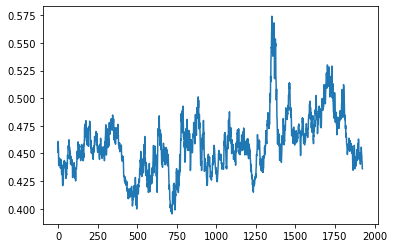

In [42]:
import matplotlib.pyplot as plt

plt.plot(total_errs)